## QA-ParsBERT model:


In [ ]:
import numpy as np
import json
import matplotlib.pyplot as plt
import time
from functools import partial
from transformers import AutoConfig, AutoTokenizer,AutoModel
import torch
from torch import nn,optim
from torch.utils.data import Dataset, DataLoader


# Dataset

In [ ]:
!git clone https://github.com/AUT-NLP/PQuAD.git
!pip install transformers  sentencepiece

fatal: destination path 'PQuAD' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.0 MB/s eta 0:00:00


In [ ]:
with open('PQuAD/Dataset/Train.json','r') as f:
    train_data = json.load(f)
train_data = train_data['data']

with open('PQuAD/Dataset/Validation.json','r') as f:
    validation_data = json.load(f)
validation_data = validation_data['data']

with open('PQuAD/Dataset/Test.json','r') as f:
    test_data = json.load(f)
test_data = test_data['data']


In [ ]:
print('number of titles of train data : ',len(train_data))
print('number of titles of validation data : ',len(validation_data))
print('number of titles of test data : ',len(test_data))

number of titles of train data :  891
number of titles of validation data :  120
number of titles of test data :  114


In [ ]:
print('number of paragraphs of train data : ',sum([len(train_data[i]['paragraphs']) for i in range(len(train_data))]))
print('number of paragraphs of validation data : ',sum([len(validation_data[i]['paragraphs']) for i in range(len(validation_data))]))
print('number of paragraphs of test data : ',sum([len(test_data[i]['paragraphs']) for i in range(len(test_data))]))

number of paragraphs of train data :  8979
number of paragraphs of validation data :  1103
number of paragraphs of test data :  1059


In [ ]:
print('number of questions of train data : ', sum([len(train_data[i]['paragraphs'][j]['qas'])
                                                   for i in range(len(train_data))
                                                   for j in range(len(train_data[i]['paragraphs']))]))

print('number of questions of validation data : ', sum([len(validation_data[i]['paragraphs'][j]['qas'])
                                                   for i in range(len(validation_data))
                                                   for j in range(len(validation_data[i]['paragraphs']))]))

print('number of questions of test data : ', sum([len(test_data[i]['paragraphs'][j]['qas'])
                                                   for i in range(len(test_data))
                                                   for j in range(len(test_data[i]['paragraphs']))]))

number of questions of train data :  63994
number of questions of validation data :  7976
number of questions of test data :  8002


In [ ]:
device = torch.device("mps")
dtype = torch.float

# preprocessing functions

In [ ]:
def get_located_answer(context_tokens, answer_tokens):
    for indx in range(len(context_tokens)-len(answer_tokens)+1):
        if answer_tokens == context_tokens[indx:indx+len(answer_tokens)]:
            return indx, len(answer_tokens)
    return None, None

def text_preprocessing(data, tokenizer):
    labels = []
    question_context = []
    unused_counte = 0
    for topic in data[:]:
        for paragraphs in topic['paragraphs']:
            context = paragraphs['context']
            context_tokens = tokenizer.tokenize(context)
            for qas in paragraphs['qas']:
                if not qas['is_impossible']:
                    question = qas['question']
                    question_tokens = tokenizer.tokenize(question)
                    tokenized = tokenizer(question, context, padding='max_length', max_length=512, return_tensors="pt")
                    for answer in qas['answers']:
                        answer_text = answer['text']
                        answer_start = answer['answer_start']
                        if context[answer_start:answer_start+len(answer_text)] != answer_text:
                            continue
                        indx, length = get_located_answer(context_tokens, tokenizer.tokenize(answer_text))
                        if indx is None:
                            unused_counte += 1
                            continue
                        question_context.append(tokenized['input_ids'])
                        label = np.zeros((tokenized['input_ids'].shape[1], 2))
                        label[indx+len(question_tokens)+2, 0] = 1.0
                        label[indx+length+len(question_tokens)+1, 1] = 1.0
                        labels.append(label)
    return torch.stack(question_context).squeeze(), torch.tensor([np.asarray(labels)]).squeeze().type(dtype), unused_counte

class CustomTextDataset(Dataset):
    def __init__(self, question_context, labels,pretrained_model):
        self.question_context = question_context
        self.labels = labels
        self.pretrained_model = pretrained_model
        self.pretrained_model.to(device)
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, indx):
        self.pretrained_model.eval()
        # return  self.pretrained_model(torch.unsqueeze(self.question_context[indx].to(device),0))[0], self.labels[indx].to(device)
        return  {'question_context': self.question_context[indx],'labels': self.labels[indx]}
        self.pretrained_model(torch.unsqueeze(self.question_context[indx].to(device),0))[0], self.labels[indx].to(device)


def custom_collate(data,pretrained_model):
    inputs = torch.stack([d['question_context'] for d in data]).to(device)
    labels = torch.stack([d['labels'] for d in data]).to(device)
    return pretrained_model(inputs)[0], labels

# metrics

In [ ]:
def exactmatchh(y_true, y_pred):
    em_score = 0
    for i in range(len(y_true)):
        if y_pred[i, 0] == y_true[i, 0] and y_pred[i, 1] == y_true[i, 1]:
            em_score += 1
    return em_score/len(y_true)

def f1scores(y_true, y_pred):
    pred_list = []
    truth_list = []
    common_list = []
    for i in range(len(y_true)):
        true_index = set(range(y_true[i,0],y_true[i,1]+1))
        pred_index = set(range(y_pred[i,0],y_pred[i,1]+1))
        common = true_index.intersection(pred_index)
        common_list.append(len(true_index))
        truth_list.append(len(truth_list))
        pred_list.append(len(pred_index))

    if sum(pred_index)==0 or sum(true_index)==0:
        return 0
    prec = sum(common)/sum(pred_index)
    rec = sum(common)/sum(truth_list)

    if (prec+rec) ==0:
        return 0

    return 2*(prec*rec)/(prec+rec)

def metrics(y_true, y_pred):
    y_pred = y_pred.detach().to('cpu').numpy()
    y_true = y_true.detach().to('cpu').numpy()
    y_pred = y_pred.argmax(axis=1)
    y_true = y_true.argmax(axis=1)
    em_score = exactmatchh(y_true, y_pred)
    f1_score = f1scores(y_true, y_pred)
    return {"em_score":em_score, "f1_score":f1_score }


def plot_results(loss,loss_val,metrics,title):
    plt.plot(range(len(loss)),loss,'b',label='train')
    plt.plot(range(len(loss)),loss_val,'r',label = 'validation')
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    plt.title(title + ' loss')
    plt.legend()
    plt.savefig(title + ' loss')
    plt.show()

    f1_scores = []
    em_scores = []
    for metrics_epoch in metrics:
        em = []
        f1 = []
        for row in metrics_epoch:
            em.append(row['em_score'])
            f1.append(row['f1_score'])
        em_scores.append(np.mean(em))
        f1_scores.append(np.mean(f1))

    plt.plot(range(len(f1_scores)),f1_scores)
    plt.xlabel('epoch')
    plt.ylabel('f1 scores')
    plt.title(title + ' f1_scores')
    plt.savefig(title + ' f1_scores')
    plt.show()

    plt.plot(range(len(em_scores)),em_scores)
    plt.xlabel('epoch')
    plt.ylabel('em scores')
    plt.title(title+' em_scores')
    plt.savefig(title+' em_scores')
    plt.show()

# QA model

In [ ]:
class QAModel(nn.Module):
    def __init__(self, embedding_hidden_size, num_labels=2):
        super(QAModel, self).__init__()
        self.num_labels = num_labels
        self.fc = nn.Linear(embedding_hidden_size, num_labels)
        self.act_func = nn.Softmax(dim=0)
        self.float()
    def forward(self, x):
        logits = self.fc(x)
        return self.act_func(logits)

# PARSBERT Model

In [ ]:
model_name="HooshvareLab/bert-base-parsbert-uncased"
parsbert_config=AutoConfig.from_pretrained(model_name)
parsbert_tokenizer=AutoTokenizer.from_pretrained(model_name)
parsbert_model=AutoModel.from_pretrained(model_name).float()

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 1.1 preprocessing

In [ ]:
question_context, labels, unused_counte = text_preprocessing(train_data, parsbert_tokenizer)
train_DS = CustomTextDataset(question_context, labels,parsbert_model)
print("unused train answers : ", unused_counte)
print("number of train QA pairs : ", len(question_context))

/var/folders/wh/xkgkz2s94qv9j7mhyld__r000000gn/T/ipykernel_2919/3702556625.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  return torch.stack(question_context).squeeze(), torch.tensor([np.asarray(labels)]).squeeze().type(dtype), unused_counte


unused train answers :  213
number of train QA pairs :  48059


In [ ]:
question_context_val, labels_val, unused_counte = text_preprocessing(validation_data, parsbert_tokenizer)
val_DS = CustomTextDataset(question_context_val, labels_val,parsbert_model)
print("unused validation answers : ", unused_counte)
print("number of validation QA pairs : ", len(question_context_val))

unused validation answers :  20
number of validation QA pairs :  8382


In [ ]:
question_context_test, labels_test, unused_counte = text_preprocessing(test_data, parsbert_tokenizer)
test_DS = CustomTextDataset(question_context_test, labels_test,parsbert_model)
print("unused test answers : ", unused_counte)
print("number of test QA pairs : ", len(question_context_test))

unused test answers :  17
number of test QA pairs :  8523


## 1.2 model

In [ ]:
for param in parsbert_model.parameters():
    param.requires_grad = False

In [ ]:
batch_size=64
n_epochs = 10
num_labels = 2
parsbert_collate = partial(custom_collate, pretrained_model=parsbert_model)

In [ ]:
checkpoint=False

In [ ]:
qa_model_parsbert = QAModel(parsbert_config.hidden_size, num_labels)
qa_model_parsbert.to(device)
optimizer = torch.optim.Adam(qa_model_parsbert.parameters(), lr=0.001)
train_loader = DataLoader(train_DS, shuffle=True, batch_size=batch_size, collate_fn=parsbert_collate)
val_loader = DataLoader(val_DS, shuffle=True, batch_size=batch_size, collate_fn=parsbert_collate)

loss_fct = nn.MSELoss()
losses = []
losses_val = []
metrics_list = []
start_epochs = 0
if checkpoint:
    checkpoint = torch.load('/content/drive/MyDrive/backup_qa_model_parsbert.pt')
    qa_model_parsbert.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epochs = checkpoint['epoch']+1
    losses = checkpoint['losses']
    losses_val = checkpoint['losses_val']
    metrics_list = checkpoint['metrics_list']

for epoch in range(start_epochs, n_epochs):
    start_epoch = time.time()
    epoch_loss = []
    qa_model_parsbert.train()
    start_batch = time.time()

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = qa_model_parsbert(X_batch)
        active_logits = logits.view(-1, num_labels)
        active_labels = y_batch.view(-1, num_labels)
        loss = loss_fct(active_logits, active_labels)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.detach().to('cpu'))
        print('batch time : ', time.time() - start_batch)
        start_batch = time.time()
    print(f'epoch {epoch}  ==> loss : {np.mean(epoch_loss)}', end=' ')
    losses.append(np.mean(epoch_loss))
    metric_list = []
    epoch_loss = []
    qa_model_parsbert.eval()
    for X_batch, y_batch in val_loader:
        logits = qa_model_parsbert(X_batch)
        active_logits = logits.view(-1, num_labels)
        active_labels = y_batch.view(-1, num_labels)
        loss = loss_fct(active_logits, active_labels)
        metric_list.append(metrics(y_batch, logits.squeeze()))
        epoch_loss.append(loss.detach().to('cpu'))
    losses_val.append(np.mean(epoch_loss))
    metrics_list.append(metric_list)
    print(f'epoch {epoch}  ==> loss val : {np.mean(epoch_loss)}', end=' ')
    print('epoch time : ', time.time() - start_epoch)

batch time :  2.5823559761047363
batch time :  2.417590856552124
batch time :  2.430432081222534
batch time :  2.420073986053467
batch time :  2.5312929153442383
batch time :  2.5514113903045654
batch time :  2.468214988708496
batch time :  2.4108481407165527
batch time :  2.4112091064453125
batch time :  2.4109880924224854
batch time :  2.52689528465271
batch time :  2.5140578746795654
batch time :  2.5914487838745117
batch time :  2.4769699573516846
batch time :  2.477949857711792
batch time :  2.430464029312134
batch time :  2.456791877746582
batch time :  2.414315700531006
batch time :  2.4152650833129883
batch time :  2.4132180213928223
batch time :  2.412189245223999
batch time :  2.409738063812256
batch time :  2.408658981323242
batch time :  2.413217067718506
batch time :  2.413365125656128
batch time :  2.4125728607177734
batch time :  2.409088134765625
batch time :  2.409385919570923
batch time :  2.4087657928466797
batch time :  2.408881902694702
batch time :  2.408810138702

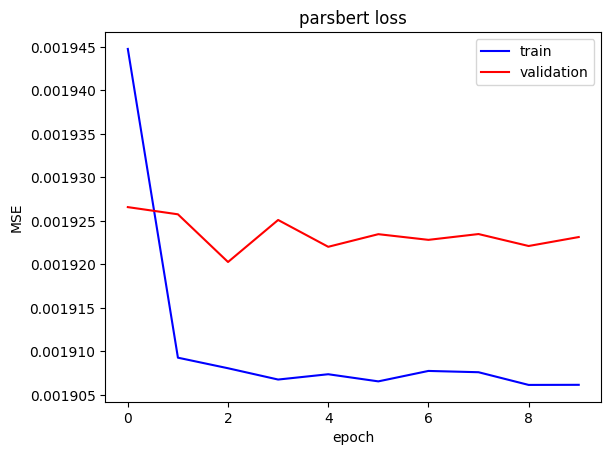

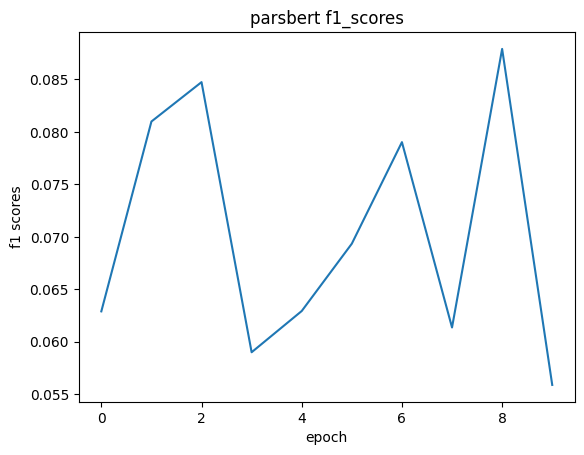

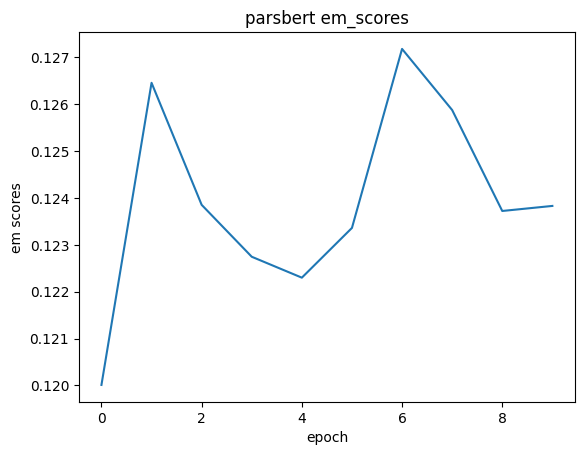

In [ ]:
plot_results(losses, losses_val, metrics_list, "parsbert")

## 1.3 model validation

In [ ]:
qa_model_parsbert.eval()
test_loader = DataLoader(test_DS, shuffle=True, batch_size=batch_size,collate_fn=parsbert_collate)
metric_list=[]
epoch_loss = []
for X_batch, y_batch in test_loader:
    logits = qa_model_parsbert(X_batch)
    active_logits = logits.view(-1, num_labels)
    active_labels = y_batch.view(-1, num_labels)
    loss = loss_fct(active_logits, active_labels)
    metric_list.append(metrics(y_batch,logits.squeeze()))
    epoch_loss.append(loss.detach().to('cpu'))

em = []
f1 = []
for row in metric_list:
    em.append(row['em_score'])
    f1.append(row['f1_score'])

print('loss test : ',np.mean(epoch_loss))
print('f1 score : ',np.mean(f1))
print('em score : ',np.mean(em))

loss test :  0.0020001705
f1 score :  0.08941490065544491
em score :  0.13419055291723203
